In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from hmpai.training import split_participants, split_participants_custom
from hmpai.pytorch.training import train_and_test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, load_model
from hmpai.pytorch.generators import MultiXArrayProbaDataset
from torch.utils.data import DataLoader
from hmpai.pytorch.normalization import *
from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.pytorch.mamba import *
from hmpai.visualization import set_seaborn_style
import os
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.utils import resample
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import mannwhitneyu, ttest_ind
from sklearn.metrics import pairwise_distances
import ast
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
import scipy.stats as st

DATA_PATH = Path(os.getenv("DATA_PATH"))

legible_labels = ["E1", "C1", "R1", "E2", "C2", "R2"]
labels_all = ["t1_1", "t1_2", "t1_3", "t2_1", "t2_2", "t2_3"]

In [2]:
set_global_seed(42)
data_paths = [DATA_PATH / "prp/stage_data_250hz_t2.nc"]
splits = split_participants_custom(data_paths, 0.15)
embs_ds = xr.load_dataset("files/prp_embeddings.nc")
# Select short condition + validation set only
embs_ds = embs_ds.where((embs_ds.condition == "short") | ((embs_ds.condition == 'long') & (embs_ds.participant.isin(splits[1]))), drop=False)


In [3]:
def project_embeddings(embs_ds):
    embs = embs_ds["embeddings"].values
    shape = embs.shape
    emb_dim = shape[-1]

    valid_mask = ~np.isnan(embs).any(axis=-1)

    embs_flat = embs.reshape(-1, emb_dim)
    valid_flat = valid_mask.reshape(-1)

    embs_valid = embs_flat[valid_flat]

    tsne = TSNE(n_components=2, random_state=42)
    proj_valid = tsne.fit_transform(embs_valid)
    proj_all = np.full((shape[0], shape[1], shape[2], 2), np.nan, dtype=np.float32)
    proj_all.reshape(-1, 2)[valid_flat] = proj_valid

    embs_ds["projection"] = (("participant", "epochs", "labels", "proj_dim"), proj_all)
    return embs_ds

In [7]:
embs_ds = project_embeddings(embs_ds)
embs_ds.to_netcdf("files/prp_embeddings_projected.nc", mode="w")

In [4]:
embs_ds = xr.load_dataset("files/prp_embeddings_projected.nc")

In [5]:
def _lighten(c, f=0.65):
    r,g,b = mcolors.to_rgb(c)
    return (1-(1-r)*f, 1-(1-g)*f, 1-(1-b)*f)

def _darken(c, f=0.8):
    r,g,b = mcolors.to_rgb(c)
    return (r*f, g*f, b*f)

def visualize_embeddings(embs_ds, ax, task="t1"):
    # keep only labels from this task
    ds = embs_ds.where(embs_ds.labels.str.startswith(task), drop=True)

    # flatten projection and mask NaNs
    proj = ds.projection.values.reshape(-1, 2)
    mask = ~np.isnan(proj).any(axis=1)

    # flattened labels (size = P*E*L_task)
    labels_flat = np.tile(ds.labels.values,
                          ds.sizes["participant"] * ds.sizes["epochs"])

    # broadcast condition to (P,E,L_task) then flatten
    cond = ds["condition"].broadcast_like(ds["projection"][..., 0]).values
    cond_flat = cond.reshape(-1)

    # only valid rows
    proj = proj[mask]
    labels_flat = labels_flat[mask]
    cond_flat = cond_flat[mask]

    # build combined categories and a color map (light for short, dark for long)
    uniq_labels = list(ds.labels.values)
    base = [sns.color_palette()[0], sns.color_palette()[2], sns.color_palette()[4]]
    color_map = {}
    for lab, base_c in zip(uniq_labels, base):
        color_map[f"{lab}|short"] = _lighten(base_c, 0.80)
        color_map[f"{lab}|long"]  = _darken(base_c, 0.80)

    combo = np.array([f"{l}|{c}" for l, c in zip(labels_flat, cond_flat)])

    # plot SHORT first (under), then LONG (over) so darker sits on top
    for cond_name, zorder in (("short", 1), ("long", 2)):
        sel = cond_flat == cond_name
        sns.scatterplot(
            x=proj[sel, 0], y=proj[sel, 1],
            hue=combo[sel],
            palette=color_map,
            s=3, ax=ax, rasterized=True,
            legend=False,
            zorder=zorder,
            alpha=0.5,
        )
    ax.set_title(f"Task {task[-1]}")
    # ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)
    ax.axis("off")

def add_panel_a_legend(ax_leg):
    base_colors = {"E": sns.color_palette()[0],
                    "C": sns.color_palette()[2],
                    "R": sns.color_palette()[4]}

    # colors per (operation, condition)
    colors = []
    labels = []
    for op, base in base_colors.items():
        colors += [_darken(base, 0.8), _lighten(base, 0.8)]
        labels += [f"{op} (long)", f"{op} (short)"]

    # build marker-only legend entries
    handles = [
        Line2D([], [], marker='o', linestyle='None',
               markerfacecolor=c, markeredgecolor='none', markersize=8)
        for c in colors
    ]

    ax_leg.axis("off")
    ax_leg.legend(
        handles, labels,
        title="Operation (Condition)",
        loc="center", frameon=True
    )

In [21]:
def calculate_distances(embs_ds, task="t1", path: Path = None):
    if path is not None:
        if path.exists():
            data = np.load(path)
            diffs = data[data.files[0]]
            return diffs
    N_BOOT = 1000
    N_SAMPLES = 1000
    # keep only labels from this task
    ds = embs_ds.where(embs_ds.labels.str.startswith(task), drop=True)
    labels = ["t1_1", "t1_2", "t1_3"] if task == "t1" else ["t2_1", "t2_2", "t2_3"]
    # flatten projection and mask NaNs
    embs = ds.embeddings.values.reshape(-1, len(ds.emb_dim))
    mask = ~np.isnan(embs).any(axis=1)
    # flattened labels (size = P*E*L_task)
    labels_flat = np.tile(ds.labels.values,
                          ds.sizes["participant"] * ds.sizes["epochs"])
    # broadcast condition to (P,E,L_task) then flatten
    cond = ds["condition"].broadcast_like(ds["projection"][..., 0]).values
    cond_flat = cond.reshape(-1)
    # only valid rows
    embs = embs[mask]
    labels_flat = labels_flat[mask]
    cond_flat = cond_flat[mask]

    diffs = np.zeros((len(labels), N_BOOT, 2), dtype=np.float32)

    for i_op, op in enumerate(labels):
        data_source = embs[(labels_flat == op) & (cond_flat == "long")]
        data_same_long = embs[(labels_flat == op) & (cond_flat == "long")]
        data_diff_long = embs[(labels_flat != op) & (cond_flat == "long")]
        for i_boot in tqdm(range(N_BOOT)):
            idx_src = np.random.choice(data_source.shape[0], size=N_SAMPLES, replace=True)
            idx_same = np.random.choice(data_same_long.shape[0], size=N_SAMPLES, replace=True)
            idx_diff = np.random.choice(data_diff_long.shape[0], size=N_SAMPLES, replace=True)

            sample_source = data_source[idx_src]
            sample_same_long = data_same_long[idx_same]
            sample_diff_long = data_diff_long[idx_diff]

            same_same_dists = cdist(sample_source, sample_source, metric='cosine')
            same_long_dists = cdist(sample_source, sample_same_long, metric='cosine')
            other_long_dists = cdist(sample_source, sample_diff_long, metric='cosine')

            same_long_diff = np.mean(np.abs(same_long_dists) - np.abs(same_same_dists))
            other_long_diff = np.mean(np.abs(other_long_dists) - np.abs(same_same_dists))
            diffs[i_op, i_boot, 0] = same_long_diff
            diffs[i_op, i_boot, 1] = other_long_diff
    np.savez(path, diffs=diffs)
    return diffs

def visualize_distances(embs_ds, ax, task="t1", path: Path = None):
    diffs = calculate_distances(embs_ds, task=task, path=path)

    # colors to match panel a (tweak if you use a different palette)
    base_colors = {"E": sns.color_palette()[0],
                    "C": sns.color_palette()[2],
                    "R": sns.color_palette()[4]}
    
    op_names = ["E", "C", "R"]
    offsets = np.linspace(-0.2, 0.2, len(op_names))

    handles = []
    labels  = []

    for i, (name, offset) in enumerate(zip(op_names, offsets)):
        y0 = diffs[i, :, 0]
        y1 = diffs[i, :, 1]
        c  = base_colors[name]
        
        n0, n1 = len(y0), len(y1)
        # mean and 95% CI
        m0 = np.mean(y0)
        m1 = np.mean(y1)

        ci0 = st.t.ppf(0.975, n0-1) * np.std(y0, ddof=1) / np.sqrt(n0)
        ci1 = st.t.ppf(0.975, n1-1) * np.std(y1, ddof=1) / np.sqrt(n1)

        # plot error bars with marker
        ax.errorbar([0 + offset], [m0], yerr=[ci0], fmt='o', color=c,
                    capsize=6, capthick=2, elinewidth=2, markersize=5, zorder=2)
        ax.errorbar([1 + offset], [m1], yerr=[ci1], fmt='o', color=c,
                    capsize=6, capthick=2, elinewidth=2, markersize=5, zorder=2)

        # connect points
        ax.plot([0 + offset, 1 + offset], [m0, m1],
                linestyle="--", color=c, linewidth=2.0, zorder=1)

        handles.append(Line2D([0], [0], linestyle="--", color=c, marker="o"))
        labels.append(f"{name} (short)")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Same (long)", "Other (long)"])
    ax.set_ylabel("Absolute Cosine\nDistance Difference")
    ax.set_xlim(-0.3, 1.3)
    ax.set_ylim(-0.05, max(0.6, np.nanmax(diffs) * 1.1))
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    
    return handles, labels
    # ax.legend(handles, labels, title="Operation (Condition)")
    


In [18]:
def plot_all():
    set_seaborn_style()
    fig = plt.figure(figsize=(6, 3), dpi=300, constrained_layout=True)
    gs  = gridspec.GridSpec(
        2, 6, figure=fig,
    )

    ax_a1 = fig.add_subplot(gs[0, 0:2])
    ax_a2 = fig.add_subplot(gs[0, 2:4])
    ax_a3 = fig.add_subplot(gs[0, 4:6])

    visualize_embeddings(embs_ds, ax_a1, task="t1")
    visualize_embeddings(embs_ds, ax_a2, task="t2")

    add_panel_a_legend(ax_a3)

    ax_b1 = fig.add_subplot(gs[1, 0:2])
    ax_b2 = fig.add_subplot(gs[1, 2:4], sharey=ax_b1)
    ax_b3 = fig.add_subplot(gs[1, 4:6])

    handles, labels = visualize_distances(embs_ds, ax_b1, task="t1", path=Path("files/dists_t1.npz"))
    visualize_distances(embs_ds, ax_b2, task="t2", path=Path("files/dists_t2.npz"))
    ax_b2.set_ylabel("")
    ax_b2.tick_params(labelleft=False)

    ax_b3.axis("off")
    ax_b3.legend(handles, labels, title="Operation (Condition)", loc="center")

    fig.text(0.01, 0.98, "a)", fontweight="bold")
    fig.text(0.01, 0.48, "b)", fontweight="bold")
    plt.savefig("../img/embeddings_result.pdf", transparent=True, bbox_inches="tight")
    plt.show()


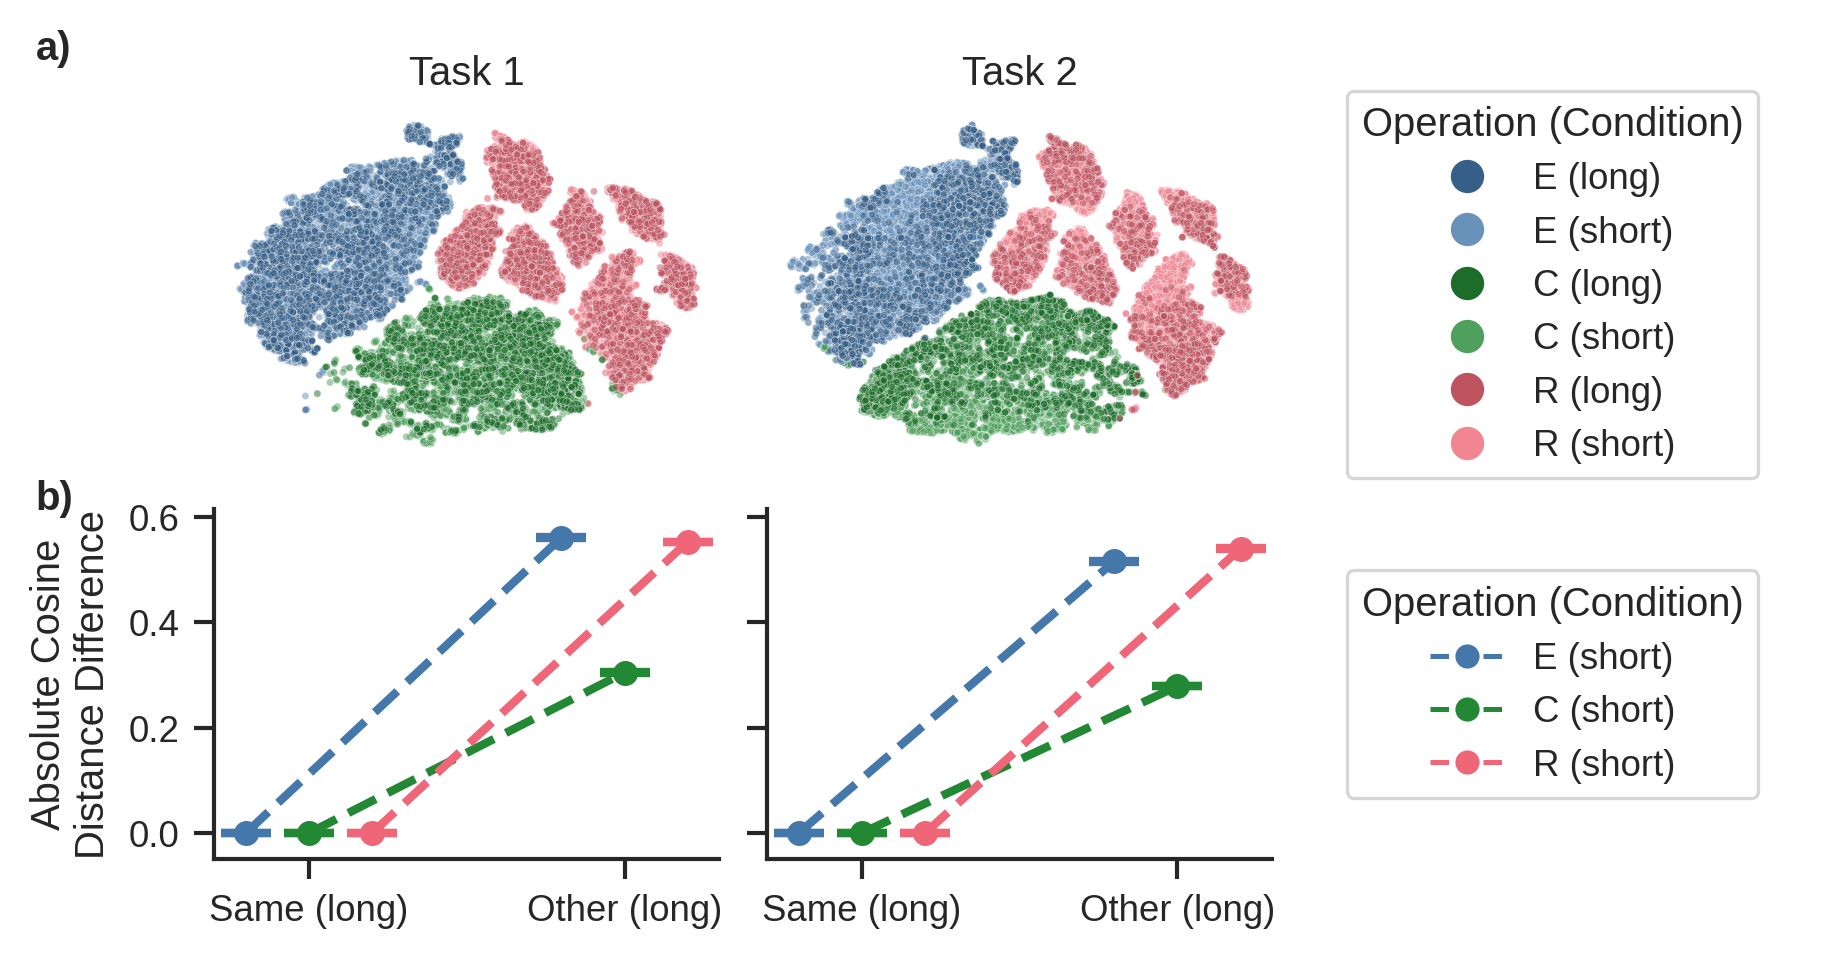

In [22]:
plot_all()